In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

c:\Users\pmarczak\NFL_contact_detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 100, 
    'valid_bs': 64,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 2
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

In [26]:
DATA_DIR = "../data"
OUTPUT_DIR = "../output_files/CNN_baseline"
MODELS_DIR = "models/CNN_baseline_example"

In [6]:

labels = expand_contact_id(pd.read_csv(f"{DATA_DIR}/sample_submission.csv"))

test_tracking = pd.read_csv(f"{DATA_DIR}/test_player_tracking.csv")

test_helmets = pd.read_csv(f"{DATA_DIR}/test_baseline_helmets.csv")

test_video_metadata = pd.read_csv(f"{DATA_DIR}/test_video_metadata.csv")

In [28]:
!mkdir -p ../work/frames

for video in tqdm(test_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i /data/test/{video} -q:v 2 -f image2 /work/frames/{video}_%04d.jpg -hide_banner -loglevel error

The syntax of the command is incorrect.
  0%|          | 0/4 [00:00<?, ?it/s]'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
100%|██████████| 4/4 [00:00<00:00, 36.56it/s]ternal command,
operable program or batch file.
100%|██████████| 4/4 [00:00<00:00, 36.07it/s]


In [7]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

test, feature_cols = create_features(labels, test_tracking, use_cols=use_cols)
test

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58168_003392_0_37084_37211,0,58168_003392,0,37084,37211,41.90,20.08,0.54,0.06,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,0,58168_003392,0,37084,38556,41.90,20.08,0.54,0.06,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,0,58168_003392,0,37084,38590,41.90,20.08,0.54,0.06,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,0,58168_003392,0,37084,39947,41.90,20.08,0.54,0.06,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49583,58172_003247_125_52521_52939,0,58172_003247,125,52521,52939,23.44,4.04,1.41,0.15,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,14.629204,False
49584,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
49585,58172_003247_125_52852_52939,0,58172_003247,125,52852,52939,32.67,2.18,2.34,0.24,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,5.270607,False
49586,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
test_filtered = test.query('not distance>2').reset_index(drop=True)
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1
test_filtered

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False,300
1,58168_003392_0_37084_G,0,58168_003392,0,37084,G,41.90,20.08,0.54,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,0,58168_003392,0,37211,46445,39.59,17.07,0.53,0.05,...,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False,300
3,58168_003392_0_37211_G,0,58168_003392,0,37211,G,39.59,17.07,0.53,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,0,58168_003392,0,38556,G,41.93,30.61,0.67,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,58172_003247_125_48241_G,0,58172_003247,125,48241,G,33.86,-1.28,0.79,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6627,58172_003247_125_48335_G,0,58172_003247,125,48335,G,44.74,3.16,4.72,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6628,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6629,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049


In [9]:
del test, labels, test_tracking
gc.collect()

22

In [10]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [11]:
video2helmets = {}
test_helmets_new = test_helmets.set_index('video')
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop=True)
    
del test_helmets, test_helmets_new
gc.collect()

100%|██████████| 4/4 [00:00<00:00, 363.63it/s]


9

In [14]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'{OUTPUT_DIR}/frames/{video}*'))))

100%|██████████| 2/2 [00:00<00:00, 44.55it/s]


In [17]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
#             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    img = cv2.imread(f'{OUTPUT_DIR}/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label

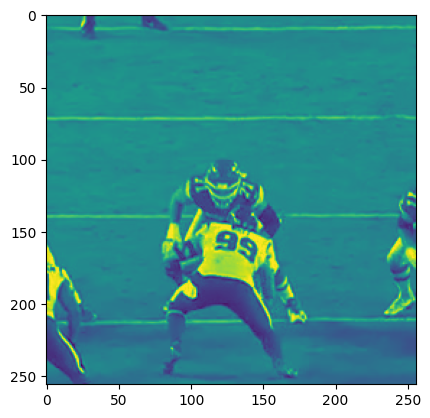

(torch.Size([26, 256, 256]),
 array([4.1900002e+01, 2.0080000e+01, 5.4000002e-01, 5.9999999e-02,
        2.5269000e+02, 2.6231000e+02, 9.2000002e-01, 8.9999998e-01,
        4.0369999e+01, 1.9879999e+01, 6.6000003e-01, 7.0000000e-02,
        1.3670000e+02, 8.8919998e+01, 8.9999998e-01, 8.8999999e-01,
        1.5430166e+00, 0.0000000e+00], dtype=float32),
 0.0)

In [18]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[0]
plt.imshow(img.permute(1,2,0)[:,:,7])
plt.show()
img.shape, feature, label

In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=False, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [31]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=CFG['num_workers'], pin_memory=True)

model = Model().to(device)
model.load_state_dict(torch.load(f'{MODELS_DIR}/resnet50_fold0.pt', map_location=torch.device('cpu')))

model.eval()
    
y_pred = [] 
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        img, feature, label = [x.to(device) for x in batch]
        output = model(img, feature).squeeze(-1)

        y_pred.extend(output.sigmoid().cpu().numpy())

y_pred = np.array(y_pred)

  0%|          | 0/104 [00:00<?, ?it/s]